## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
    emotions_code = ["NEU", "FEA","ANG"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)
    files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
    emotions_code_s = ["a", "f","n"]
    datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 
    examples = []
    files_filters = dict()
    files_filters["NEU"] = 0
    files_filters["FEA"] = 0
    files_filters["ANG"] = 0
    files_filters["a"] = 0
    files_filters["f"] = 0
    files_filters["n"] = 0
    examples = get_features(datas_files, get_code_crema_d, files_filters)
    examples_s = get_features(datas_files_s, get_code_savee, files_filters)
    return examples + examples_s

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    datas = select_elements(entries, 'NEU', 896,"without_stress")
    datas += select_elements(entries, 'ANG', 550, "stress")
    datas += select_elements(entries, 'FEA', 550, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


In [40]:
#funciones de redes neuronales
def previous_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

def new_RNN_a():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7987477638640429
-----------------------
Resumen
Fold score (Accuracy score): 0.8102678571428571
Fold score (Accuracy score): 0.7516778523489933
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.8232662192393736
Fold score (Accuracy score): 0.8344519015659956
'''
def new_RNN_b():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8090339892665475
-----------------------
Resumen
Fold score (Accuracy score): 0.8214285714285714
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.8098434004474273
Fold score (Accuracy score): 0.8277404921700223
'''

def new_RNN_c():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7754919499105546
-----------------------
Resumen
Fold score (Accuracy score): 0.7879464285714286
Fold score (Accuracy score): 0.7539149888143176
Fold score (Accuracy score): 0.7718120805369127
Fold score (Accuracy score): 0.7628635346756152
Fold score (Accuracy score): 0.8008948545861297
'''

def double_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7920393559928444
-----------------------
Resumen
Fold score (Accuracy score): 0.78125
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.7941834451901566
Fold score (Accuracy score): 0.8165548098434005
'''

#fail tarda mucho
def triple_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7991949910554562
-----------------------
Resumen
Fold score (Accuracy score): 0.7991071428571429
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.814317673378076
Fold score (Accuracy score): 0.7762863534675615
Fold score (Accuracy score): 0.8210290827740492
'''
def dense_Layer():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dense(50))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7844364937388193
-----------------------
Resumen
Fold score (Accuracy score): 0.7589285714285714
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.796420581655481
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8076062639821029
'''

def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model


In [41]:
model = new_RNN()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 40, 50)            10400     
                                                                 
 activation_6 (Activation)   (None, 40, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 activation_7 (Activation)   (None, 50)                0         
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 30,702
Trainable params: 30,702
Non-trai

In [47]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 70
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1788, 40) y:(1788, 2)
Test - X:(448, 40) y:(448, 2)
Epoch 1/50
56/56 [==============================] - 12s 93ms/step - loss: 0.6582 - accuracy: 0.5811 - val_loss: 0.6139 - val_accuracy: 0.6830
Epoch 2/50
56/56 [==============================] - 4s 71ms/step - loss: 0.5959 - accuracy: 0.6689 - val_loss: 0.5461 - val_accuracy: 0.7188
Epoch 3/50
56/56 [==============================] - 4s 68ms/step - loss: 0.5687 - accuracy: 0.6907 - val_loss: 0.5762 - val_accuracy: 0.6853
Epoch 4/50
56/56 [==============================] - 4s 67ms/step - loss: 0.5525 - accuracy: 0.6957 - val_loss: 0.5140 - val_accuracy: 0.7411
Epoch 5/50
56/56 [==============================] - 4s 69ms/step - loss: 0.5370 - accuracy: 0.7053 - val_loss: 0.5065 - val_accuracy: 0.7522
Epoch 6/50
56/56 [==============================] - 4s 67ms/step - loss: 0.5270 - accuracy: 0.7170 - val_loss: 0.5164 - val_accuracy: 0.7522
Epoch 7/50
56/56 [==============================] - 4s 70ms/step - loss: 0.5143 - 

56/56 [==============================] - 4s 65ms/step - loss: 0.5318 - accuracy: 0.7216 - val_loss: 0.5764 - val_accuracy: 0.6644
Epoch 7/50
56/56 [==============================] - 4s 74ms/step - loss: 0.5294 - accuracy: 0.7110 - val_loss: 0.5489 - val_accuracy: 0.6890
Epoch 8/50
56/56 [==============================] - 4s 64ms/step - loss: 0.5161 - accuracy: 0.7323 - val_loss: 0.5346 - val_accuracy: 0.7002
Epoch 9/50
56/56 [==============================] - 4s 72ms/step - loss: 0.5068 - accuracy: 0.7401 - val_loss: 0.5348 - val_accuracy: 0.7025
Epoch 10/50
56/56 [==============================] - 3s 58ms/step - loss: 0.4866 - accuracy: 0.7473 - val_loss: 0.5299 - val_accuracy: 0.6935
Epoch 11/50
56/56 [==============================] - 3s 58ms/step - loss: 0.4850 - accuracy: 0.7535 - val_loss: 0.5032 - val_accuracy: 0.7248
Epoch 12/50
56/56 [==============================] - 3s 58ms/step - loss: 0.4725 - accuracy: 0.7636 - val_loss: 0.5131 - val_accuracy: 0.7181
Epoch 13/50
56/56 [==

Epoch 12/50
56/56 [==============================] - 4s 77ms/step - loss: 0.4870 - accuracy: 0.7451 - val_loss: 0.5213 - val_accuracy: 0.6980
Epoch 13/50
56/56 [==============================] - 4s 76ms/step - loss: 0.4756 - accuracy: 0.7518 - val_loss: 0.4744 - val_accuracy: 0.7427
Epoch 14/50
56/56 [==============================] - 5s 81ms/step - loss: 0.4603 - accuracy: 0.7652 - val_loss: 0.6777 - val_accuracy: 0.5951
Epoch 15/50
56/56 [==============================] - 4s 73ms/step - loss: 0.4991 - accuracy: 0.7311 - val_loss: 0.4744 - val_accuracy: 0.7315
Epoch 16/50
56/56 [==============================] - 4s 72ms/step - loss: 0.4661 - accuracy: 0.7613 - val_loss: 0.4720 - val_accuracy: 0.7226
Epoch 17/50
56/56 [==============================] - 4s 73ms/step - loss: 0.4745 - accuracy: 0.7423 - val_loss: 0.5243 - val_accuracy: 0.6868
Epoch 18/50
56/56 [==============================] - 5s 81ms/step - loss: 0.4557 - accuracy: 0.7680 - val_loss: 0.4946 - val_accuracy: 0.7204
Epoch 

Epoch 18/50
56/56 [==============================] - 4s 80ms/step - loss: 0.4460 - accuracy: 0.7753 - val_loss: 0.4677 - val_accuracy: 0.7562
Epoch 19/50
56/56 [==============================] - 4s 76ms/step - loss: 0.4488 - accuracy: 0.7798 - val_loss: 0.4689 - val_accuracy: 0.7808
Epoch 20/50
56/56 [==============================] - 4s 76ms/step - loss: 0.4292 - accuracy: 0.7809 - val_loss: 0.4466 - val_accuracy: 0.7785
Epoch 21/50
56/56 [==============================] - 5s 83ms/step - loss: 0.4416 - accuracy: 0.7759 - val_loss: 0.4911 - val_accuracy: 0.7763
Epoch 22/50
56/56 [==============================] - 4s 74ms/step - loss: 0.4327 - accuracy: 0.7848 - val_loss: 0.4608 - val_accuracy: 0.7651
Epoch 23/50
56/56 [==============================] - 5s 83ms/step - loss: 0.4170 - accuracy: 0.7921 - val_loss: 0.4031 - val_accuracy: 0.8076
Epoch 24/50
56/56 [==============================] - 4s 72ms/step - loss: 0.4273 - accuracy: 0.7870 - val_loss: 0.4188 - val_accuracy: 0.8054
Epoch 

56/56 [==============================] - 5s 81ms/step - loss: 0.4353 - accuracy: 0.7781 - val_loss: 0.4488 - val_accuracy: 0.7763
Epoch 24/50
56/56 [==============================] - 5s 82ms/step - loss: 0.4541 - accuracy: 0.7596 - val_loss: 0.4270 - val_accuracy: 0.7651
Epoch 25/50
56/56 [==============================] - 4s 80ms/step - loss: 0.4490 - accuracy: 0.7708 - val_loss: 0.4300 - val_accuracy: 0.7740
Epoch 26/50
56/56 [==============================] - 5s 81ms/step - loss: 0.4271 - accuracy: 0.7831 - val_loss: 0.3990 - val_accuracy: 0.8054
Epoch 27/50
56/56 [==============================] - 5s 82ms/step - loss: 0.4289 - accuracy: 0.7904 - val_loss: 0.4026 - val_accuracy: 0.7942
Epoch 28/50
56/56 [==============================] - 5s 81ms/step - loss: 0.4269 - accuracy: 0.7781 - val_loss: 0.3943 - val_accuracy: 0.8143
Epoch 29/50
56/56 [==============================] - 5s 83ms/step - loss: 0.4403 - accuracy: 0.7764 - val_loss: 0.4220 - val_accuracy: 0.7919
Epoch 30/50
56/56 

In [48]:
#https://keras.io/api/callbacks/early_stopping/
callbacks = []
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=30,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]

num_epochs = 100
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Epoch 1/100
56/56 [==============================] - 6s 100ms/step - loss: 0.3595 - accuracy: 0.8161 - val_loss: 0.3786 - val_accuracy: 0.8121
Epoch 2/100
56/56 [==============================] - 5s 93ms/step - loss: 0.3703 - accuracy: 0.8150 - val_loss: 0.3670 - val_accuracy: 0.8166
Epoch 3/100
56/56 [==============================] - 5s 92ms/step - loss: 0.3454 - accuracy: 0.8379 - val_loss: 0.4027 - val_accuracy: 0.7785
Epoch 4/100
56/56 [==============================] - 6s 98ms/step - loss: 0.3646 - accuracy: 0.8228 - val_loss: 0.4298 - val_accuracy: 0.8031
Epoch 5/100
56/56 [==============================] - 5s 95ms/step - loss: 0.3483 - accuracy: 0.8301 - val_loss: 0.4377 - val_accuracy: 0.7651
Epoch 6/100
56/56 [==============================] - 5s 98ms/step - loss: 0.3795 - accuracy: 0.8038 - val_loss: 0.4018 - val_accuracy: 0.8210
Epoch 7/100
56/56 [==============================] - 5s 98ms/step - loss: 0.3483 - accuracy: 0.8273 - val_loss: 0.3718 - val_accuracy: 0.8210
Epoch

In [43]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.497694194316864 val_accuracy: 0.8165547847747803
El algoritmo acerto 365 veces sobre los 447 casos.


In [44]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

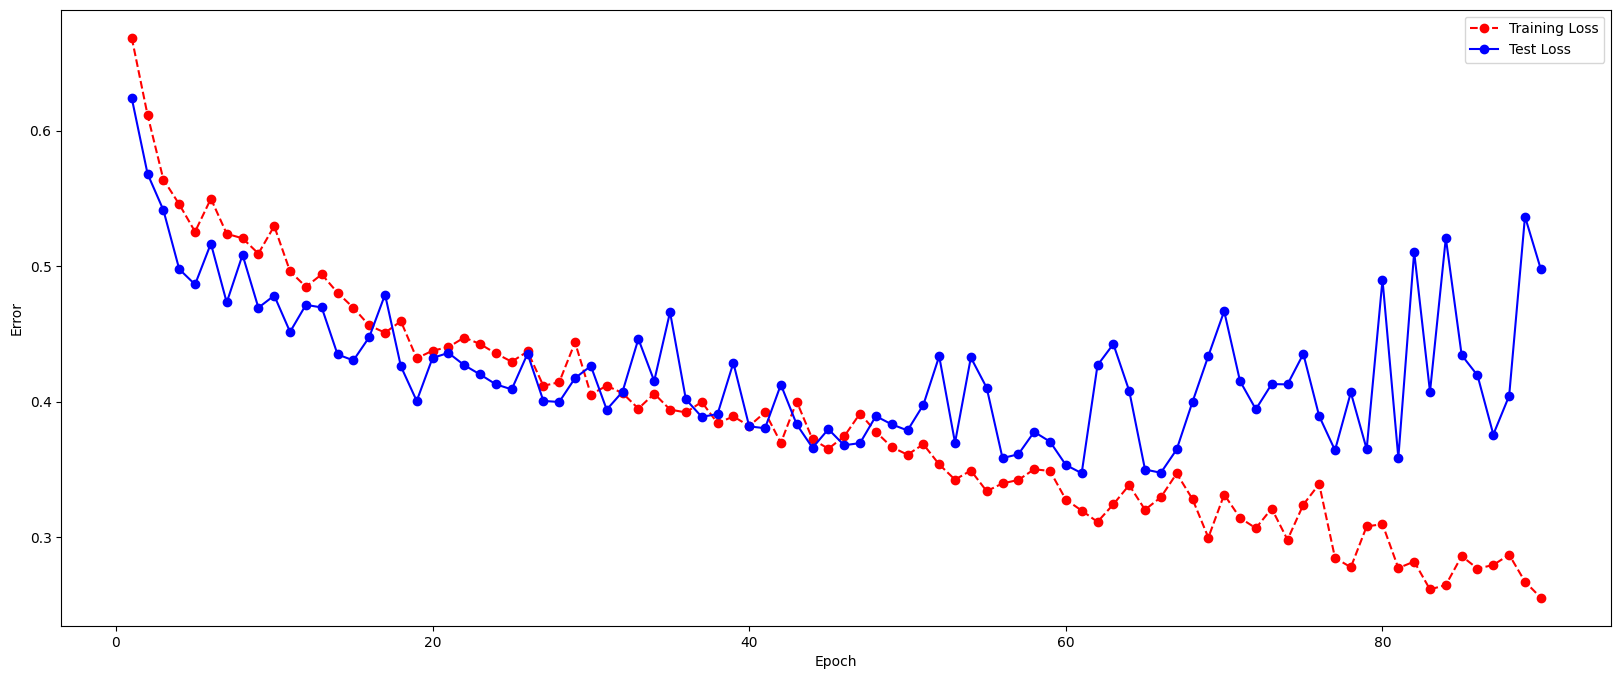

In [45]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [17]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
